In [69]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Normalization
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from keras import layers
pd.set_option('display.max_rows', 50)
from tensorflow.keras import optimizers
import random


In [70]:
df_merged = pd.read_csv("data_final_20210826_v3.csv")

In [71]:
df_merged = df_merged.iloc[98:]

In [72]:
df_merged.shape

(553, 16)

In [73]:
df_merged["tweet_date"] = pd.to_datetime(df_merged["tweet_date"])

In [74]:
df_merged = df_merged.groupby([pd.Grouper(key='tweet_date',freq='D'), "party"]).agg({
    "reply_count": "sum", 
    "retweet_count": "sum",
    "like_count": "sum",
    "avg_len_of_tweet": "mean" ,
    "avg_followers_count": "mean" ,
    "avg_following_count": "mean" ,
    "avg_user_tweet_count" :"mean",
    "avg_ff_ratio" :"mean",
    "share_of_tweets" :"mean",
    "share_unique_users": "mean",
    "weighted_sentiment" : "mean",
    "share_of_positive_tweets": "mean",
    "share_of_negative_tweets" : "mean",
    "poll": "mean"}) 

In [75]:
df_merged = df_merged.replace(np.nan, -9999)

In [76]:
df_merged_final_day = np.array(df_merged.iloc[-7:])

In [77]:
df_merged_final_day = np.expand_dims(df_merged_final_day, axis = 0)

In [78]:
df_merged = df_merged.iloc[:-7]

In [79]:
def splitting_data(df):
    
    split_percentage = 0.80
    split_index = round(split_percentage * len(df)) 
    
    for num in range(split_index, split_index + 7):
        if df_merged[num:(num + 1)].index[0][1] == "AFD":
            split_index = num
        else:
            pass
    df_train = df[:split_index]
    df_test = df[split_index:]
    
    return df_train, df_test

In [80]:
df_train, df_test = splitting_data(df_merged)

In [81]:
def subsequence(df, length):
    last_possible_start = len(df) - length 
    random_start = random.randrange(0,last_possible_start,7)
    X = df[random_start:random_start + length]
    y = df["poll"][(random_start + length ) : (random_start + length + 7)]
    
    return X, y

In [82]:
def multiple_subsequences(df, length):
    
    list_of_X = []
    list_of_y = []
    
    number_of_subsequences = round(len(df) / length)
    
    for num in range(number_of_subsequences):
        temporary_X, temporary_y = subsequence(df, length)
        list_of_X.append(temporary_X)
        list_of_y.append(temporary_y)
        
    
    return list_of_X, list_of_y

    
    
    

In [83]:
X_train , y_train = multiple_subsequences(df_train, 28)
X_test , y_test = multiple_subsequences(df_test, 28)

In [84]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [85]:
# X_test = df_merged_test.to_numpy().reshape(1,7,14)
# X_train = df_merged.to_numpy().reshape(35,7,14)
# y_test = df_merged_test["poll"].to_numpy().reshape(18,7)
# y_train = y.to_numpy().reshape(4,7)

In [86]:
# def subsequence(df, length):
#     X = []
#     y = []
#     counter = 0
#     counter_y = 21
#     last_possible = len(df) - length
#     subsequences = round(len(df) / (length) )
    
#     for num in range(subsequences - 1):
#         X.append(df[counter: counter + length])
#         y.append(df["poll"][counter_y: (counter_y + 7)])
#         counter = counter + 7
#         counter_y = counter_y + 7
    
#     return (X, y)

# X_train, y_train = subsequence(df_train, 3)
# X_test, y_test = subsequence(df_test, 3)

In [87]:
# pd.DataFrame(y_testing.groupby(by = y_testing.index).mean()).set_index(y_testing.columns)

In [88]:
# pd.DataFrame(y_testing.groupby(by = y_testing.index).mean().unstack()).set_index()

In [89]:
# X_test = df_merged_test.to_numpy().reshape(1,7,14)
# X_train = df_merged.to_numpy().reshape(35,7,14)
# y_test = df_merged_test["poll"].to_numpy().reshape(1,7,1)
# y_train = y.to_numpy().reshape(93,7)

In [90]:
# X_test = df_merged_test.to_numpy().reshape(1,7,14)
# X_train = df_merged.to_numpy().reshape(35,7,14)
# y_test = df_merged_test["poll"].to_numpy().reshape(1,7,1)
# y_train = y.to_numpy().reshape(93,7)

In [100]:
model = Sequential()
model.add(layers.Masking(mask_value=-9999., input_shape=(X_train[0].shape)))
model.add(layers.LSTM(units=64, activation='tanh', return_sequences=True))
model.add(layers.LSTM(units=32, activation='tanh', return_sequences=False))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(7, activation='linear'))


In [101]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, 28, 14)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 28, 64)            20224     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 357       
Total params: 34,647
Trainable params: 34,647
Non-trainable params: 0
_________________________________________________________________


In [102]:
%%time

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

history = model.fit(X_train, y_train ,
          epochs=50, 
          batch_size=1, 
          verbose=1, 
          validation_split=0.2,
          shuffle = False
     )



Epoch 1/50
12/12 [==============================] - 9s 337ms/step - loss: 250.2393 - mae: 14.1956 - val_loss: 243.6093 - val_mae: 14.0693
Epoch 2/50
12/12 [==============================] - 0s 34ms/step - loss: 240.2448 - mae: 13.9192 - val_loss: 230.3627 - val_mae: 13.6760
Epoch 3/50
12/12 [==============================] - 1s 50ms/step - loss: 223.2778 - mae: 13.3861 - val_loss: 208.8926 - val_mae: 12.9533
Epoch 4/50
12/12 [==============================] - 1s 56ms/step - loss: 196.7812 - mae: 12.4312 - val_loss: 176.7876 - val_mae: 11.7192
Epoch 5/50
12/12 [==============================] - 1s 51ms/step - loss: 159.5804 - mae: 10.8825 - val_loss: 133.0867 - val_mae: 9.7441
Epoch 6/50
12/12 [==============================] - 1s 62ms/step - loss: 114.6074 - mae: 8.6650 - val_loss: 88.2265 - val_mae: 7.5296
Epoch 7/50
12/12 [==============================] - 1s 44ms/step - loss: 73.3836 - mae: 6.9236 - val_loss: 52.0520 - val_mae: 6.0409
Epoch 8/50
12/12 [==============================

In [103]:
model.evaluate(x = X_test, y= y_test )

1/1 [==============================] - 2s 2s/step - loss: 9.0431 - mae: 2.2143


[9.043123245239258, 2.214262008666992]

In [104]:
df_prediction = pd.DataFrame(model.predict(df_merged_final_day)).rename( \
                        columns = {0:'AFD',1:'CDU',2:'FDP',3: 'GRUENE',4: 'LINKE', 5:'OTHER', 6: 'SPD'}).round(2)

In [105]:
df_prediction

,AFD,CDU,FDP,GRUENE,LINKE,OTHER,SPD
0,10.02,26.91,11.31,18.379999,6.5,7.38,15.92


In [106]:
df_prediction.index = ["pred"]

In [107]:
pd.DataFrame((df_prediction.iloc[0] * 100) / np.sum(df_prediction.iloc[0])).T.round(1)

,AFD,CDU,FDP,GRUENE,LINKE,OTHER,SPD
pred,10.4,27.9,11.7,19.1,6.7,7.7,16.5


In [99]:
def plot_loss_mae(history):

# --- LOSS

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model MAE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
# --- MAE

    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

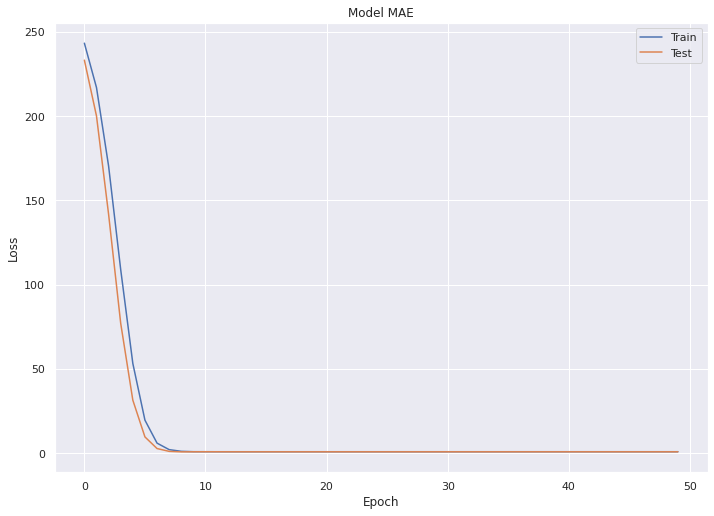

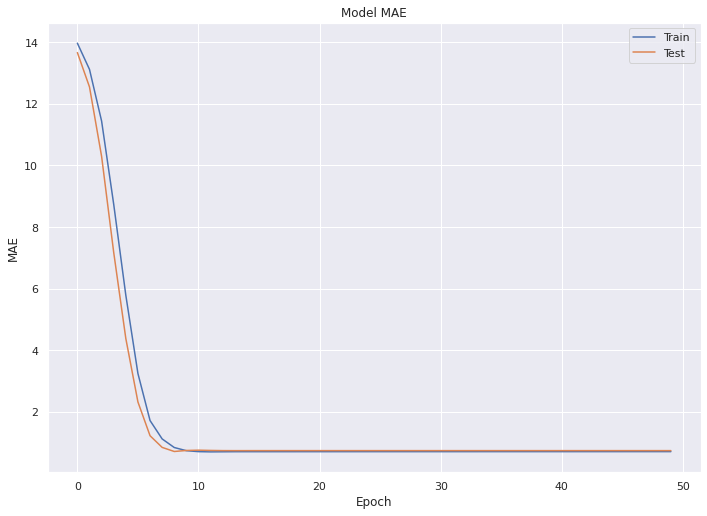

In [61]:
plot_loss_mae(history)

<AxesSubplot:xlabel='tweet_date'>

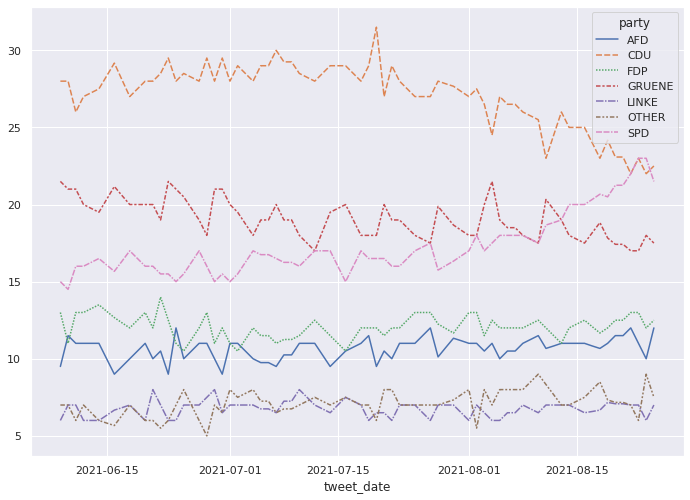

In [62]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot( data = df_merged["poll"].unstack())
